### 라이브러리

In [1]:
import numpy as np
import cv2
import torch

from infer import InferenceHelper
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation

from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm

from pytictoc import TicToc

C:\Users\KihwanRyoo\anaconda3\envs\hellopytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 커널 생성(대상이 있는 픽셀을 강조) - optional
def clear_image(image):
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    # 커널 적용 
    image = cv2.filter2D(np.array(image), -1, kernel)
    return image

In [3]:
def predict_segmentation(image_path):
    image = Image.open(image_path)
    processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
    model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")

    inputs = processor(image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    prediction = processor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
    print(prediction.keys()) # dict_keys(['segmentation', 'segments_info'])
    return model, prediction

In [4]:
def draw_panoptic_segmentation(model, segmentation, segments_info):
    # get the used color map
    viridis = cm.get_cmap('viridis', torch.max(segmentation))
    fig, ax = plt.subplots()
    ax.imshow(segmentation)
    instances_counter = defaultdict(int)
    handles = []
    # for each segment, draw its legend
    for segment in segments_info:
        segment_id = segment['id']
        segment_label_id = segment['label_id']
        segment_label = model.config.id2label[segment_label_id]
        label = f"{segment_label}-{instances_counter[segment_label_id]}"
        instances_counter[segment_label_id] += 1
        color = viridis(segment_id - 1)
        handles.append(mpatches.Patch(color=color, label=label))
    ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5))
    print(f"choose a label to be focused (1 ~ {len(segments_info)})")

In [5]:
def blur_image(image_path, label, split_num):
    infer_helper = InferenceHelper(dataset='nyu')

    # predict depth of a single pillow image
    img = Image.open(image_path)  # any rgb pillow image
    bin_centers, predicted_depth = infer_helper.predict_pil(img)
    
    # 초점 label을 기준으로 한 depth 차이 맵핑
    depth_std = abs(predicted_depth[0][0] - predicted_depth[0][0][prediction["segmentation"] == label].mean()) * np.array(prediction["segmentation"] != label).astype(int)
    dep_max = np.max(depth_std)
    dep_min = np.min(depth_std)
    
    channel1_label = prediction["segmentation"] == label
    label3channel = np.repeat(channel1_label[:,:,np.newaxis],3,-1)
    img_filtered = img * np.array(label3channel)

    split = np.arange(0, dep_max, dep_max/split_num)

    result = np.zeros(np.array(img).shape)
    k = 1
    for i in split:
        channel1_range = np.logical_and(depth_std > i, depth_std <= (i + dep_max/split_num))
        channel3_range = np.repeat(channel1_range[:,:,np.newaxis],3,-1)
        img_range = img * np.array(channel3_range)
        img_range_blur = cv2.GaussianBlur(img_range, (k, k), 0)
        k += 2
        result += img_range_blur
    result += img_filtered
    
    ### 몇 가지 트릭...
    result += img_filtered * 0.1
    result += np.array(img) * 0.4
    result /= 1.6

    print(result.shape)
    plt.imshow(result.astype(np.uint16))

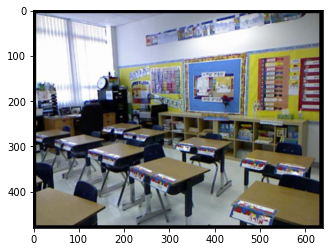

In [6]:
image = Image.open("test_imgs/classroom__rgb_00283.jpg")
plt.imshow(image)

`label_ids_to_fuse` unset. No instance will be fused.


dict_keys(['segmentation', 'segments_info'])
choose a label to be focused (1 ~ 30)


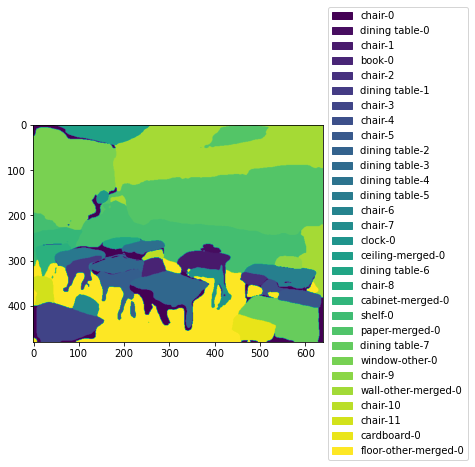

In [7]:
t = TicToc()
t.tic()

image_path = "test_imgs/classroom__rgb_00283.jpg"
# image_path = "test_imgs/bicycle.jpg"
model, prediction = predict_segmentation(image_path)
draw_panoptic_segmentation(model, **prediction)

Loading base model ()...

Using cache found in C:\Users\KihwanRyoo/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


Done.
Removing last two layers (global_pool & classifier).
Building Encoder-Decoder model..Done.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(480, 640, 3)
Elapsed time is 7.351334 seconds.


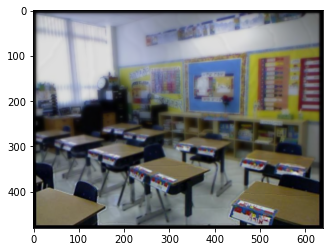

In [8]:
label = 6
split_num = 15
blur_image(image_path, label, split_num)

t.toc()